# <center>Neural Networks Learning</center>

Implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

## Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize as op
import time

Load data from a matlab file. The data is in the dictionary format with X representing 5000 20x20 pixel images in a 5000 x 400 matrix and y representing the number corresponding to the image in 5000 x 1 vector.

In [2]:
pixelsmat = scipy.io.loadmat('ex4data1.mat')
print(pixelsmat.keys())
X = pixelsmat['X']
y = pixelsmat['y']
print(X.shape, y.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(5000, 400) (5000, 1)


Check the different classes in our dataset

In [3]:
print("Different classes", set(y.reshape(y.shape[0])))

Different classes {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


Initialize the number of samples and pixels variable

In [4]:
numsamples = X.shape[0]
numpixels1d = X.shape[1]
numpixels2d = int(np.sqrt(numpixels1d))
print(numpixels1d, numpixels2d)

400 20


### Visualizing the data

Visualize images using randomly selected 100 rows from X matrix. The image can be displayed using imshow function available in matplotlib library.

In [5]:
num_img = 100
rows = cols = int(np.sqrt(num_img))
indices = np.random.randint(0,numsamples, size=num_img)

In [6]:
imgArr = np.zeros((num_img, numpixels1d))
for i in range(np.size(indices)):
    imgArr[i] = X[indices[i]]

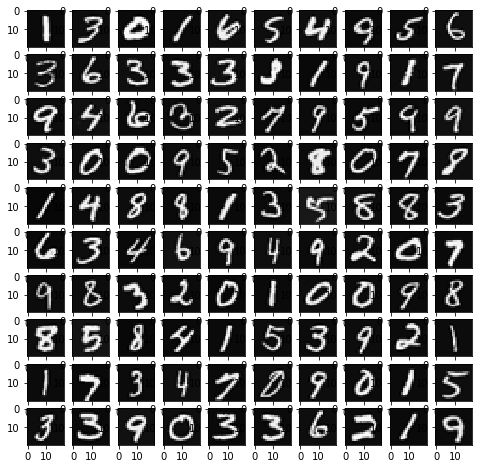

In [7]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, np.size(indices)+1):
    img = imgArr[i-1].reshape(numpixels2d, numpixels2d)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.T, cmap='gray', origin="upper")
plt.show()

### Model Representation

Since the images are of size 20 x 20, this gives us 400 input layer units. The ex4weights.mat file contains already trained paramenters $\theta^{(1)}$ and $\theta^{(2)}$ which are of dimensions 25 x 401 and 10 x 26 accounting the extra bias unit.

<img src="NeuralNetworkModel.png">

The units in all layers except input is calculated as sigmoid function of weighted sum of inputs
<br>The hypothesis is defined as
<br>$$ a = g(\theta^Tx) $$
<br>where g is the Sigmoid function
<br>$$ g(z) = \frac{1}{1 + e^{-z}} $$

Load the weights into Theta1 and Theta2

In [8]:
weightsmat = scipy.io.loadmat('ex4weights.mat')
print(weightsmat.keys())
Theta1 = weightsmat['Theta1']
Theta2 = weightsmat['Theta2']
print(Theta1.shape, Theta2.shape)
tc = 0
tg = 0

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
(25, 401) (10, 26)


Append bias unit to X matrix

In [9]:
y_set = set(y.reshape(y.shape[0]))
X1 = np.hstack((np.ones((X.shape[0], 1)), X))
print("X1 shape", X1.shape)

X1 shape (5000, 401)


From the given data:
* A sample in matrix X which corresponds to first layer is of size (401, 1).
* The weights for first layer is of size (25, 401).
* The second layer is of size (25, 1).
[//]: #
Thus for __each sample__, the second layer can be calculated using vectorized implementation as $ a^{(2)} = \theta^{(1)}.a^{(1)} $
<br> In general, for each sample, a layer _l_ can be calculated as $ a^{(l)} = \theta^{(l-1)}.a^{(l-1)} $

### Feedforward function

In [10]:
def sigmoid(z):
    return (1/(1+(np.exp(-z))))

In [11]:
def fwdpropgate(theta, x):
    z = x.dot(theta.T)
    a = sigmoid(z)
    return a

### Cost function

<br>The cost function is 
<br>$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}log((h_\theta(x^{(i)}))_k) - (1 - y_k^{(i)})log(1 - (h_\theta(x^{(i)}))_k] + R$$
$$ R = \frac{\lambda}{2m}[\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\theta_{ji}^{(l)})^2] $$
<br> $m$ - number of samples, $K$ - number of classes, $L$ - number of Layers, $s_l$ - number of units in Layer $l$, $\lambda$ - Regularization factor
<br> $R$ is the regularization term which excludes the bias values
<br> In our case with one input layer and one hidden layer, this can be rewritten as
$$ R = \frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\theta_{jk}^{(1)})^2 + \sum_{j=1}^{10}\sum_{k=1}^{25}(\theta_{jk}^{(2)})^2] $$

In [12]:
def getThetaFromThetaVec(ThetaVec, Theta1Size, Theta2Size):
    # Compute length to split Theta parameters from unrolled vector
    Theta1Len = Theta1Size[0]*Theta1Size[1]
    # Get Theta1 and Theta2
    Theta1 = ThetaVec[:Theta1Len].reshape(Theta1Size)
    Theta2 = ThetaVec[Theta1Len:].reshape(Theta2Size)
    return (Theta1, Theta2)

In [13]:
def getNumSamplesFeaturesClasses(X, y):
    num_samples = X.shape[0]
    num_features = X.shape[1]
    num_classes = len(set(y.reshape(y.shape[0])))
    return (num_samples, num_features, num_classes)

In [14]:
def getEncodedy(y, num_classes):
    y_mod = y.ravel() - 1
    yv = np.eye(num_classes)[y_mod]
    return yv

In [15]:
def ypred(Theta1, Theta2, x):
    # Compute predicted values using forward propogation
    # This will output predicted values for all samples
    # using matrix multiplication
    a2 = fwdpropgate(Theta1, x)
    a2 = np.hstack((np.ones((x.shape[0], 1)), a2))
    a3 = fwdpropgate(Theta2, a2)
    return (a2,a3)

In [16]:
def computecost(yv, yhat):
    '''
    
        yhat represents output unit matrix. Its dimension is (m x K)
        yv represents one hot encoded matrix based on actual y values. Its dimension is (m x K)

        The double sum can be computed as element-wise scalar product for each element in the matrices
        followed by sum of all elements in the resultant matrix
        Example m = 3, K = 2. Both A and B are 2D arrays of size (m x K)
        A = [             B = [
                a b              m n
                c d              o p
                e f              q r
            ]                 ]

        DoubleSum = a.m + b.n + c.o + d.p + e.q + f.r
        For efficient implementation, this is done through, dot product of flattened vectors of length m.K
        
        For more details, please check https://www.coursera.org/learn/machine-learning/discussions/all/threads/AzIrrO7wEeaV3gonaJwAFA
        
    '''
    cost = -(yv.ravel().dot(np.log(yhat.ravel())) + (1 - yv.ravel()).dot(np.log(1 -yhat.ravel())))
    return (cost/yv.shape[0])

In [17]:
def computeregterm(Theta1, Theta2, l, num_samples):
    # remove the bias column for both theta vectors and flatten it
    Theta1 = Theta1[:,1:].flatten()
    Theta2 = Theta2[:,1:].flatten()
    regparam = Theta1.T.dot(Theta1) + Theta2.T.dot(Theta2)
    return ((l*regparam)/(2*num_samples))

In [18]:
def cost(ThetaVec, Theta1Size, Theta2Size, X, y, l, pa):
    global tc
    st = time.time()
    # Get Theta1 (25 x 401) and Theta2 (10 x 26)
    (Theta1, Theta2) = getThetaFromThetaVec(ThetaVec, Theta1Size, Theta2Size)
    # Get number of samples, features and classes
    (num_samples, num_features, num_classes) = getNumSamplesFeaturesClasses(X, y)
    
    # Compute hidden and output layer matrix
    # X  - 5000 x 401, Theta1 - 25 x 401, a2 - 5000 x 26 after adding bias column
    # a2 - 5000 x 26,  Theta2 - 10 x 26,  a3(yhat) - 5000 x 10
    a2, yhat = ypred(Theta1, Theta2, X)
    
    # Create a "One hot encoded" matrix based in classes in y vector
    yv = getEncodedy(y, num_classes)
    # Compute cost
    cost = (computecost(yv, yhat))
    # Compute accuracy
    if(pa == 1):
        max_ind = np.argmax(yhat, axis = 1)
        count = np.sum(y.ravel() == (max_ind+1))
    # Account regularization into cost
    if(l > 0):
        cost += computeregterm(Theta1, Theta2, l, num_samples)
    # Compute accuracy
    if(pa == 1):
        accuracy = (count/num_samples)
        print("Accuracy is {:%}, Cost is {}".format(accuracy, cost))
    et = time.time()
    tc += (et - st)
    return cost

In [19]:
# Unroll Theta1 and Theta2 into single vector
ThetaVec = np.concatenate((Theta1.ravel(), Theta2.ravel()))
# Cost without regularization
print("Cost without regularization is", cost(ThetaVec, Theta1.shape, Theta2.shape, X1, y, 0, 0))
# Cost with regularization
print("Cost with regularization", cost(ThetaVec, Theta1.shape, Theta2.shape, X1, y, 1, 1))

Cost without regularization is 0.2876291651613189
Accuracy is 97.520000%, Cost is 0.38376985909092365
Cost with regularization 0.38376985909092365


## Backpropagation

Backpropagation allows to calculate gradient of the cost function which in turn will be used along with the above cost function by the optimization function to calculate the optimum Theta vectors.
1. Implement backpropagation to compute partial derivatives.
    * Implement sigmoid gradient function $g'(z) = \frac{d}{dz}g(z) = g(z)(1 - g(z))$
    * Randomly initialize the theta vectors for symmetry breaking.
2. Use gradient checking to confirm that your backpropagation works. Then disable gradient checking.
3. Use gradient descent or a built-in optimization function to minimize the cost function with the weights in theta.

In [20]:
def sigmoidgrad(a):
    return (a*(1-a))

One efective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice can be set as
$$\epsilon_{init} = \frac{\sqrt(6)}{\sqrt(s_l + s_{l+1})}$$

In [21]:
# Randomly initialize the weights Theta1 (25 x 401) and Theta2 (10 x 26) to small values
# For more info check https://web.stanford.edu/class/ee373b/nninitialization.pdf
epsilon_init = 0.12;
num_features = X1.shape[1]
num_classes = len(set(y.reshape(y.shape[0])))
num_units_l1 = num_features
num_units_l2 = 25
num_units_l3 = num_classes
Theta1_r = np.random.random((num_units_l2, num_units_l1)) * 2 * epsilon_init - epsilon_init;
Theta2_r = np.random.random((num_units_l3, num_units_l2+1)) * 2 * epsilon_init - epsilon_init;
Theta_r = np.concatenate((Theta1_r.ravel(), Theta2_r.ravel()))
print(Theta1_r.shape, Theta2_r.shape, Theta_r.shape)

(25, 401) (10, 26) (10285,)


To compute gradient, first perform forward propagation and then compute backwards "error term" $\delta_j^{(l)}$ for all units except bias unit from output unit till input unit.

<img src="BackpropagationUpdates.png">

Implement gradient calculation function
$$ \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ for j = 0$$
$$ \frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)}\ \ \ \ \ \ \ \ \ \ \ for j \ge 1 $$
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{l+1}(a^{(l)})^T $$
In our case, for efficient vectorized implementation,
$$ \delta^{(3)} = a^{(3)} - y $$
$$ \delta^{(2)} = \delta^{(3)}.\Theta^2 * g'(z^{(2)}) $$
$$ \Delta^{(1)} = (\delta^{(2)})^T.X $$
$$ \Delta^{(2)} = (\delta^{(3)})^T.a^{(2)} $$
<br> $m$ - number of samples, $\lambda$ - Regularization factor

In [22]:
def gradient(ThetaVec, Theta1Size, Theta2Size, X, y, l, pa):
    global tg
    st = time.time()
    # Get Theta1 (25 x 401) and Theta2 (10 x 26)
    (Theta1, Theta2) = getThetaFromThetaVec(ThetaVec, Theta1Size, Theta2Size)
    # Get number of samples, features and classes
    (num_samples, num_features, num_classes) = getNumSamplesFeaturesClasses(X, y)
    # Initialize gradient vectors
    grad_d1 = np.zeros((Theta1Size))
    grad_d2 = np.zeros((Theta2Size))
    # Create a "One hot encoded" matrix based in classes in y vector
    yv = getEncodedy(y, num_classes)

    # 1. Forward propogate to compute hidden (a2 (5000 x 26)) and outer layer (a3/yhat (5000 x 10)) units
    a2, yhat = ypred(Theta1, Theta2, X)
    
    # 2. Backward propogate to compute d3 (5000 x 10) and d2 (5000 x 26) and remove bias column from d2 (5000 x 25)
    d3 = yhat - yv
    d2 = d3.dot(Theta2) * sigmoidgrad(a2)
    d2 = d2[:,1:]

    # 3. Compute gradient matrix
    grad1 = (d2.T.dot(X))/num_samples
    grad2 = (d3.T.dot(a2))/num_samples
    
    # 4. Account regularization into gradient matrix exluding the bias column
    if(l > 0):
        grad1[:,1:] += (Theta1[:,1:]*l/num_samples)
        grad2[:,1:] += (Theta2[:,1:]*l/num_samples)
    # Unroll gradient matrix into a single vector
    grad = np.concatenate((grad1.ravel(), grad2.ravel()))
    et = time.time()
    tg += (et - st)
    return grad

#### Gradient Checking
Sanity method to check if gradient calculation is working correctly
<br>Implement function to calculate approximate gradient matrix
<br>If backpropagation implementation is correct, the relative diference between gradient and gradientApprox is less than 1e-9.

In [23]:
def gradientcheck(ThetaVec, Theta1Size, Theta2Size, X, y, l):
    # Compute gradient for original theta parameters
    grad = gradient(ThetaVec, Theta1Size, Theta2Size, X, y, l, 0)
    # Intitialize gradient vector and epsilon as 10^-4
    gradApprox = np.zeros((ThetaVec.shape))
    epsilon = 0.0001
    # Compute cost for gradApprox, by changing one value at a time
    for i in range(ThetaVec.shape[0]):
        ThetaVecP = np.copy(ThetaVec)
        ThetaVecM = np.copy(ThetaVec)
        ThetaVecP[i] += epsilon
        ThetaVecM[i] -= epsilon
        JP = cost(ThetaVecP, Theta1Size, Theta2Size, X, y, l, 0)
        JM = cost(ThetaVecM, Theta1Size, Theta2Size, X, y, l, 0)
        gradApprox[i] = (JP - JM)/(2*epsilon)
    return (grad, gradApprox)

Generate random data of small size for gradient checking otherwise it will be very slow and computationally expensive

In [24]:
def getRandData(rows, cols):
    num_elems = rows * (cols+1)
    W = (np.sin(np.array(np.arange(1,num_elems+1))))/10
    return W.reshape(rows, cols+1)

In [25]:
input_layer_size = 3;
hidden_layer_size = 5;
num_labels = 3;
m = 5;
ThetaT1 = getRandData(hidden_layer_size, input_layer_size)
ThetaT2 = getRandData(num_labels, hidden_layer_size);
XT  = getRandData(m, input_layer_size - 1);
XT = np.hstack((np.ones((XT.shape[0], 1)), XT))
yt  = (1 + np.mod(np.arange(1,m+1), num_labels)).reshape(m, 1)
ThetaVecT = np.concatenate((ThetaT1.ravel(), ThetaT2.ravel()))
(grad, gradApprox) = gradientcheck(ThetaVecT, ThetaT1.shape, ThetaT2.shape, XT, yt, 1)
print(grad - gradApprox)

[ 7.39475668e-12 -7.73273806e-13  4.74464218e-13 -1.46139698e-12
  4.39316118e-12  9.79648654e-13  4.91589408e-13  1.85249385e-12
 -6.55514532e-12 -4.03347494e-13  1.21500032e-14 -1.10437874e-12
 -9.39691033e-12  5.44096018e-13  2.02796287e-12 -4.53751620e-13
 -5.75027005e-12 -3.02398384e-12  1.24660915e-12  1.69384298e-12
  7.93554111e-12  5.33378897e-13  3.12216919e-12 -2.19763097e-12
  1.76131332e-12  2.07583950e-13  6.26139418e-12  1.95224392e-12
 -6.84077794e-13  6.37252751e-12  1.69134151e-12  1.52720891e-12
  6.28826158e-12  2.27814989e-12  1.79012360e-12  2.98160108e-12
  5.19230492e-13 -1.77566989e-12]


### Learning parameters using Advanced Optimization

Use the optimization method in scipy library.

In [26]:
l = 1
tc = tg = 0
st = time.time()
Result = op.minimize(fun = cost, 
                         x0 = Theta_r, 
                         args = (Theta1_r.shape, Theta2_r.shape, X1, y, l, 0),
                         method = 'CG',
                         jac = gradient,
                        options = {'maxiter': 50});
et = time.time()
print("Time take to optimize", (et-st))
print("Total Time take to calculate cost", tc)
print("Total Time take to calculate gradient", tg)
optimal_theta = Result.x;
cost(optimal_theta, Theta1_r.shape, Theta2_r.shape, X1, y, l, 1)

Time take to optimize 1.4820380210876465
Total Time take to calculate cost 0.6272187232971191
Total Time take to calculate gradient 0.7680857181549072
Accuracy is 96.200000%, Cost is 0.45757566385647286


0.45757566385647286